# <center>BIBLIOTECAS  </center>

In [5]:
import pandas as pd

from sympy import symbols, diff

import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy.stats import weibull_min


%matplotlib inline
from scipy.stats import norm

pd.set_option('display.max_columns', None)

#<center> FUNÇÕES AUXILIARES DO PROGRAMA </center>


In [11]:
def gera_distribuicao_normal(n_simulacoes=1000000, mu=0, sigma=1):
    """
    cria distribuição normal com média e desvio padrão de imput

    :param n_simulacoes: tamanho do vetor
    :param mu: média da distribuicao
    :param sigma: desvio padrão
    :return: array com valores gerados seguindo a distribuição Normal
    """
    lista_valores_px = []
    acumulador = 0
    while acumulador <= n_simulacoes:
        lista_valores_px.append(random.normalvariate(mu=mu, sigma=sigma))
        acumulador = acumulador + 1
    return np.array(lista_valores_px)


def gera_distribuicao_extremo_tipo_1(n_simulacoes=1000000, mu=50, sigma=5):
    """
    cria distribuição extremo tipo 1 (Gumbel) com média e desvio padrão de imput

    :param n_simulacoes: tamanho do vetor
    :param mu: média da distribuicao
    :param sigma: desvio padrão
    :return: array com valores gerados seguindo a distribuição Extremo Tipo 1
    """
    lista_valores_px = []
    acumulador = 0
    while acumulador <= n_simulacoes:
        lista_valores_px.append(((np.log(-np.log(np.random.uniform()))) * sigma) + mu)
        acumulador = acumulador + 1
    return np.array(lista_valores_px)


def gera_distribuicao_weibull_two_params(n_simulacoes, lam, k):
    """

    cria distribuição weibull  de dois parametros de imput fator de modulo e escala

    :param n_simulacoes: number of samples
    :param lam: scale beta
    :param k: shape alpha
    :return: array com valores gerados seguindo a distribuição Weibull
    """

    n = n_simulacoes

    x = weibull_min.rvs(k, loc=0, scale=lam, size=n)
    return x


def gera_distribuicao_log_normal(n_simulacoes=1000000, mu=38, sigma=3.8):
    """
    cria distribuição Lognormal paramertros media e desvio padrao
    :param n_simulacoes: número de simulações
    :param mu: média
    :param sigma: desvio padrão
    :return: array com valores gerados seguindo a distribuição Log Normal
    """
    n = n_simulacoes
    x = np.random.lognormal(mu, sigma, n)
    return x


def calculate_normal_equivalent_log_normal(mu=38, delta_f=0.1):
    """
    calculo da normal equivalente a partir da distribuição log normal
    :param mu: media
    :param delta_f:
    :return: media e desvio padrao da normal equivalente
    """
    qsi = np.sqrt(np.log(1 + delta_f ** 2))
    lambda_f = np.log(mu) - (0.5 * qsi ** 2)
    mu_norm = mu * (1 - np.log(mu) + lambda_f)
    sigma_norm = qsi * mu
    return mu_norm, sigma_norm


def calculate_normal_equivalent_log_normal_2(mu=27.64, sigma=3.79):
    """
    Two-Parameter Equivalent NormalTransformation Rackwitz-Fiessler method:
    :param mu: media
    :param sigma: desvio padrao
    :return: media e desvio padrao da normal equivalente
    """
    delta_f = sigma / mu
    qsi = np.sqrt(np.log(1 + delta_f ** 2))
    lambd_f = np.log(mu) - (0.5 * (qsi ** 2))
    cdf = (1 / (np.sqrt(2 * np.pi) * qsi * mu)) * (np.exp(-0.5 * ((np.log(mu) - lambd_f) / qsi) ** 2))
    inv_pdf = (np.log(mu) - lambd_f) / qsi
    ppf = (1 / (np.sqrt(2 * np.pi))) * np.exp(-0.5 * inv_pdf ** 2)

    sigma_nomr_y = ppf / cdf
    mu_normr_y = mu - (inv_pdf * sigma_nomr_y)

    return mu_normr_y, sigma_nomr_y


def calculate_normal_equivalent_extremo_tipo_1(mu=50, sigma=5):
    """
    Two-Parameter Equivalent NormalTransformation Rackwitz-Fiessler method:
    Normal Equivalente a partir da distribuição de extremo tipo I
    :param sigma:
    :param mu: media
    :return:
    """
    #### T:
    u_n = mu
    a_n = 1 / sigma

    ##### Calulando Cdf (função de probabilidade Acumulada da distribuicao:)

    cdf_star = np.exp(-(np.exp(-a_n * (mu - u_n))))

    ##### calculando PDF ( função de densidade de probabilidade original da distribuicao):
    pdf_star = a_n * np.exp(-a_n * (mu - u_n)) * np.exp(-np.exp(-a_n * (mu - u_n)))

    sigma_norm = (norm.pdf(norm.ppf(cdf_star)) / pdf_star)
    mu_norm = mu - ((norm.ppf(cdf_star)) * sigma_norm)

    return mu_norm, sigma_norm


def gera_grafico_distribuicao(dist, label="Normal", name='test'):
    """
    gera gráfico da distribuição
    :param dist: vetor da distribuicao
    :param label: legenda
    :param name: nome do grafico
    :return: gráfico
    """
    sns.set(style="white", palette="muted", color_codes=True)

    sns.despine(left=True)

    sns.displot(dist, label=label, color="BLUE")
    plt.title(name)
    plt.legend()
    plt.show()



#<center> RESOLUÇÃO VIA FORM </center>

In [7]:
##### inicio do problema :
##### construção do data frame e contadores:
data_resultados=pd.DataFrame()
i=0
dif_beta=0.1

data_resultados["Iteração"]=[]
data_resultados["beta"]=[]
data_resultados["G(u)"]=[]
data_resultados["Grad_G(u)"]=[]
data_resultados["(U_x,U_y)"]=[]

list_i=[]
list_grad=[]
list_g_U=[]
list_mpp=[]
list_beta=[]

#### CONSTANTES MATERIAL COMPÓSITO:
rho_fibra=0.2 #Percentual de Fibra
rho_matriz=0.8 #Percentual de Resina

#### DEFININDO DISTRIBUIÇÕES DE PROBABILIDADE INICIAIS (médias, desvio padrao):

d_h=(0.2,0.01) # ~ Normal (m)
d_t=(0.02,0.001) # ~ Normal (m)
d_sigma_fibra=(3516000000,175800000) # ~ Normal (m)
d_E_fibra=(234430000000,11721500000) # ~ Normal (N/m^2)
d_E_matriz=(3350000000,167500000) # ~ Normal (N/m^2)
d_b=(0.05,0.0025) # ~ Normal (m)
d_q=(100000,5000) # ~ Extremo tipo I (N)
d_l=(2,0.100) # ~ Normal (m)


###### DEFINIÇÃO DAS VARIÁVEIS ALEÁTORIAS NO ESPAÇO ORIGINAL E REDUZIDO:
h,t,sigma_fibra,E_fibra,E_matriz,b,q,l,h_reduzido,t_reduzido,sigma_fibra_reduzido,E_fibra_reduzido,E_matriz_reduzido,b_reduzido,q_reduzido,l_reduzido = symbols('h t sigma_fibra E_fibra E_matriz b q l h_reduzido t_reduzido sigma_fibra_reduzido E_fibra_reduzido E_matriz_reduzido b_reduzido q_reduzido l_reduzido', real=True)

###### DEFINIÇÃO DA FUNÇÃO DE PERFORMANCE DO PROBLEMA NO ESPAÇO ORIGINAL:

g = ((2/(h+(2*t)))*(sigma_fibra/E_fibra)*(rho_fibra*E_fibra+rho_matriz*E_matriz)*((t/12)*((h**3)+((2*b)*((4*t**2)+(3*(h**2)))))))-((q*(l**2))/2)


#### NORMALIZAR VARIÁVEL EXTREMO TIPO I:
q_N=calculate_normal_equivalent_extremo_tipo_1(d_q[0],d_q[1])


### VETOR DAS VARIAVEIS ALEÁTORIAS NO ESPAÇO REDUZIDO:
X=np.array([d_h[0]+h_reduzido*d_h[1],d_t[0]+t_reduzido*d_t[1],d_sigma_fibra[0]+sigma_fibra_reduzido*d_sigma_fibra[1],
            d_E_fibra[0]+E_fibra_reduzido*d_E_fibra[1],d_E_matriz[0]+E_matriz_reduzido*d_E_matriz[1],
            d_b[0]+b_reduzido*d_b[1],
            q_N[0]+q_reduzido*q_N[1],
            d_l[0]+l_reduzido*d_l[1]])

##### FUNÇÃO DE PERFOMANCE NO ESPAÇO REDUZIDO:
G_u= ((2/(X[0]+(2*X[1])))*(X[2]/X[3])*(rho_fibra*X[3]+rho_matriz*X[4])*((X[1]/12)*((X[0]**3)+((2*X[5])*((4*X[1]**2)+(3*(X[0]**2)))))))-((X[6]*(X[7]**2))/2)

##### PONTO DE PARTIDA:
mpp_star = np.array([0,0,0,0,0,0,0,0], dtype=float)

#### TOLERÂNCIA DO BETA:
toll=0.000005

#### ÍNICIO DA ITERAÇÃO:
while  dif_beta> toll:
  list_i.append(i)

#################### GRADIENTE ########################
  dgu_dh_reduzido= (diff(G_u, h_reduzido)).subs(h_reduzido,mpp_star[0]).subs(t_reduzido,mpp_star[1]).subs(sigma_fibra_reduzido,mpp_star[2]).subs(E_fibra_reduzido,mpp_star[3]).subs(E_matriz_reduzido,mpp_star[4]).subs(b_reduzido,mpp_star[5]).subs(q_reduzido,mpp_star[6]).subs(l_reduzido,mpp_star[7])
  dgu_dt_reduzido=(diff(G_u, t_reduzido)).subs(h_reduzido,mpp_star[0]).subs(t_reduzido,mpp_star[1]).subs(sigma_fibra_reduzido,mpp_star[2]).subs(E_fibra_reduzido,mpp_star[3]).subs(E_matriz_reduzido,mpp_star[4]).subs(b_reduzido,mpp_star[5]).subs(q_reduzido,mpp_star[6]).subs(l_reduzido,mpp_star[7])
  dgu_dsigma_fibra_reduzido=(diff(G_u, sigma_fibra_reduzido)).subs(h_reduzido,mpp_star[0]).subs(t_reduzido,mpp_star[1]).subs(sigma_fibra_reduzido,mpp_star[2]).subs(E_fibra_reduzido,mpp_star[3]).subs(E_matriz_reduzido,mpp_star[4]).subs(b_reduzido,mpp_star[5]).subs(q_reduzido,mpp_star[6]).subs(l_reduzido,mpp_star[7])
  dgu_dE_fibra_reduzido=(diff(G_u, E_fibra_reduzido)).subs(h_reduzido,mpp_star[0]).subs(t_reduzido,mpp_star[1]).subs(sigma_fibra_reduzido,mpp_star[2]).subs(E_fibra_reduzido,mpp_star[3]).subs(E_matriz_reduzido,mpp_star[4]).subs(b_reduzido,mpp_star[5]).subs(q_reduzido,mpp_star[6]).subs(l_reduzido,mpp_star[7])
  dgu_dE_matriz_reduzido=(diff(G_u, E_matriz_reduzido)).subs(h_reduzido,mpp_star[0]).subs(t_reduzido,mpp_star[1]).subs(sigma_fibra_reduzido,mpp_star[2]).subs(E_fibra_reduzido,mpp_star[3]).subs(E_matriz_reduzido,mpp_star[4]).subs(b_reduzido,mpp_star[5]).subs(q_reduzido,mpp_star[6]).subs(l_reduzido,mpp_star[7])
  dgu_db_reduzido=(diff(G_u, b_reduzido)).subs(h_reduzido,mpp_star[0]).subs(t_reduzido,mpp_star[1]).subs(sigma_fibra_reduzido,mpp_star[2]).subs(E_fibra_reduzido,mpp_star[3]).subs(E_matriz_reduzido,mpp_star[4]).subs(b_reduzido,mpp_star[5]).subs(q_reduzido,mpp_star[6]).subs(l_reduzido,mpp_star[7])
  dgu_dq_reduzido=(diff(G_u, q_reduzido)).subs(h_reduzido,mpp_star[0]).subs(t_reduzido,mpp_star[1]).subs(sigma_fibra_reduzido,mpp_star[2]).subs(E_fibra_reduzido,mpp_star[3]).subs(E_matriz_reduzido,mpp_star[4]).subs(b_reduzido,mpp_star[5]).subs(q_reduzido,mpp_star[6]).subs(l_reduzido,mpp_star[7])
  dgu_dl_reduzido=(diff(G_u, l_reduzido)).subs(h_reduzido,mpp_star[0]).subs(t_reduzido,mpp_star[1]).subs(sigma_fibra_reduzido,mpp_star[2]).subs(E_fibra_reduzido,mpp_star[3]).subs(E_matriz_reduzido,mpp_star[4]).subs(b_reduzido,mpp_star[5]).subs(q_reduzido,mpp_star[6]).subs(l_reduzido,mpp_star[7])

##### GRADIENTE CALCULADO NO MPP STAR:
  gradiente_gu_mpp=np.array([dgu_dh_reduzido,dgu_dt_reduzido,dgu_dsigma_fibra_reduzido,dgu_dE_fibra_reduzido,dgu_dE_matriz_reduzido,dgu_db_reduzido,dgu_dq_reduzido,dgu_dl_reduzido],dtype=float)
  list_grad.append(gradiente_gu_mpp)

#### FUNÇÃO DE PERFORMANCE DO ESPAÇO REDUZIDO CALCULADO NO MPP STAR
  G_u_mpp=((2/(X[0].subs(h_reduzido,mpp_star[0])+(2*X[1].subs(t_reduzido,mpp_star[1]))))*(X[2].subs(sigma_fibra_reduzido,mpp_star[2])/X[3].subs(E_fibra_reduzido,mpp_star[3]))*(rho_fibra*X[3].subs(E_fibra_reduzido,mpp_star[3])+rho_matriz*X[4].subs(E_matriz_reduzido,mpp_star[4]))*((X[1].subs(t_reduzido,mpp_star[1])/12)*((X[0].subs(h_reduzido,mpp_star[0])**3)+((2*X[5].subs(b_reduzido,mpp_star[5]))*((4*X[1].subs(t_reduzido,mpp_star[1])**2)+(3*(X[0].subs(h_reduzido,mpp_star[0])**2)))))))-((X[6].subs(q_reduzido,mpp_star[6])*(X[7].subs(l_reduzido,mpp_star[7])**2))/2)
  list_g_U.append(G_u_mpp)

###MÓDULO DO VETOR GRADIENTE CALCULADO NO MPP
  mod_gradiente_gu_mpp= np.linalg.norm(gradiente_gu_mpp)

#### NORMA
  ao=np.array([gradiente_gu_mpp[0]/mod_gradiente_gu_mpp,gradiente_gu_mpp[1]/mod_gradiente_gu_mpp,gradiente_gu_mpp[2]/mod_gradiente_gu_mpp,gradiente_gu_mpp[3]/mod_gradiente_gu_mpp,gradiente_gu_mpp[4]/mod_gradiente_gu_mpp,gradiente_gu_mpp[5]/mod_gradiente_gu_mpp,gradiente_gu_mpp[6]/mod_gradiente_gu_mpp,gradiente_gu_mpp[7]/mod_gradiente_gu_mpp])

#### BETA
  beta_0=np.linalg.norm(mpp_star)

#### NOVO MPP STAR
  mpp_star=np.multiply(ao, -1)
  mpp_star=(np.multiply(mpp_star, (beta_0+(G_u_mpp/mod_gradiente_gu_mpp)))).astype(float)
  list_mpp.append(mpp_star)

#### BETA CORRIGIDO * MPP
  beta_c=np.linalg.norm(mpp_star)
  list_beta.append(beta_c)

#### ITERAÇÃO E CONVERGÊNCIA
  i+=1
  dif_beta=abs(beta_c-beta_0)

#### compila resultados
data_resultados["Iteração"]=list_i
data_resultados["beta"]=list_beta
data_resultados["G(u)"]=list_g_U
data_resultados["Grad_G(u)"]=list_grad
data_resultados["(U_x,U_y)"]=list_mpp

#### COMPUTA A PROBABILIDADE DE FALHA:
pf= float (norm.cdf(-data_resultados.iloc[-1:].beta))
beta= float (data_resultados.iloc[-1:].beta)

#### VERIFICAÇÃO FUNÇÃO DE PERFORMANCE NAS MÉDIAS INICIAIS:
if ((2/(d_h[0]+(2*d_t[0])))*(d_sigma_fibra[0]/d_E_fibra[0])*(rho_fibra*d_E_fibra[0]+rho_matriz*d_E_matriz[0])*((d_t[0]/12)*((d_h[0]**3)+((2*d_b[0])*((4*d_t[0]**2)+(3*(d_h[0]**2)))))))-((d_q[0]*(d_l[0]**2))/2) > 0:
    pf= float (norm.cdf(-data_resultados.iloc[-1:].beta))
else:
  print ("Na média a função de performance Falha necessário alterar valor de beta")
  pf= float (norm.cdf(-(-data_resultados.iloc[-1:].beta)))

print ("\nbeta" , beta)
print ("probabilidade de falha" , round (pf,2)*100,"%")
#### FIM MÉTODO FORM


beta 0.14805397095227968
probabilidade de falha 44.0 %


In [8]:
data_resultados

,Iteração,beta,G(u),Grad_G(u),"(U_x,U_y)"
0,0,0.148065,4693.43245239195,"[16106.888538156376, 8838.138838885809, 10407....","[-0.0752360742947968, -0.0412833843566321, -0...."
1,1,0.148059,-0.206325351435225,"[15988.05630293889, 8758.498291838416, 10319.5...","[-0.0746684272292043, -0.04090449019878878, -0..."
2,2,0.148054,-0.144537536893040,"[15989.054298182904, 8759.121270682286, 10320....","[-0.07466619324307061, -0.04090362251822358, -..."


#<center> RESOLUÇÃO VIA MONTE CARLO </center>

In [9]:
#### DISTRIBUIÇÕES DE PROBABILIDADE INICIAIS VARIÁVEIS ALEÁTORIAS:
# d_h=(0.2,0.01) # ~ Normal (m)
# d_t=(0.02,0.001) # ~ Normal (m)
# d_sigma_fibra=(3516000000,175800000) # ~ Normal (m)
# d_E_fibra=(234430000000,11721500000) # ~ Normal (N/m^2)
# d_E_matriz=(3350000000,167500000) # ~ Normal (N/m^2)
# d_b=(0.05,0.0025) # ~ Normal (m)
# d_q=(100000,5000) # ~ Extremo tipo I (N)
# d_l=(2,0.100) # ~ Normal (m)

### VETOR NÚMEROS ALEÁTORIOS:
v_h=gera_distribuicao_normal(mu=d_h[0], sigma=d_h[1])
v_t=gera_distribuicao_normal(mu=d_t[0], sigma=d_t[1])
v_sigma_fibra=gera_distribuicao_normal(mu=d_sigma_fibra[0], sigma  = d_sigma_fibra[1])
v_E_fibra=gera_distribuicao_normal(mu=d_E_fibra[0], sigma=d_E_fibra[1])
v_E_matriz=gera_distribuicao_normal(mu=d_E_matriz[0], sigma=d_E_matriz[1])
v_b=gera_distribuicao_normal(mu=d_b[0], sigma  = d_b[1])
v_q=gera_distribuicao_extremo_tipo_1(mu=d_q[0], sigma  = d_q[1])
v_l=gera_distribuicao_normal(mu=d_l[0], sigma  = d_l[1])


#### CRIAÇÃO DO DATAFRAME:
df=pd.DataFrame()
df["h"]=v_h
df["t"]=v_t
df["sigma_fibra"]=v_sigma_fibra
df["E_fibra"]=v_E_fibra
df["E_matriz"]=v_E_matriz
df["b"]=v_b
df["q"]=v_q
df["l"]=v_l

#### CÁLCULO DA FUNÇÃO DE PERFORMANCE:
df["funcao_de_performance"]=(((2/(df["h"]+(2*df["t"])))*(df["sigma_fibra"]/df["E_fibra"])*(rho_fibra*df["E_fibra"]+rho_matriz*df["E_matriz"])*((df["t"]/12)*((df["h"]**3)+((2*df["b"])*((4*df["t"]**2)+(3*(df["h"]**2)))))))-((df["q"]*(df["l"]**2))/2))

#### EXIBINDO PRIMEIRAS LINHAS DO DATAFRAME:
df.head()


### CALCULANDO PROBABILIDADE DE FALHA PELA DEFINIÇÃO:

print ("probabilidade de falha" , round ((df.loc[df.funcao_de_performance<0].shape[0]/df.shape[0]),2)*100,"%")

### CALCULANDO BETA MONTE CARLO:
beta =df.funcao_de_performance.mean()/df.funcao_de_performance.std()

print ("beta Monte Carlo" ,beta)

### CALCULANDO PROBABILIDADE DE FALHA (integral de zero até beta)
#norm.cdf(-beta)

probabilidade de falha 34.0 %
beta Monte Carlo 0.4250736333677789


#<center> PDF DA FUNÇÃO DE PERFOMANCE </center>

<Figure size 640x480 with 0 Axes>

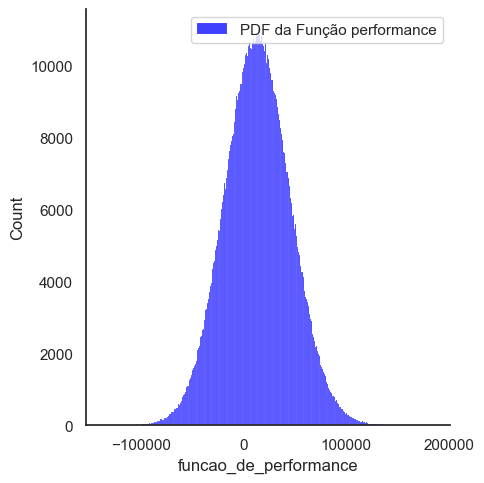

In [12]:
gera_grafico_distribuicao(df.funcao_de_performance, label='PDF da Função performance',name='')